# Self-Driving Car Engineer Nanodegree


## Project: **Advanced Lane Finding** 

---

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
--- 

## Import Packages

In [1]:
#importing some useful packages
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Camera Calibration 

### Chessboard Corners

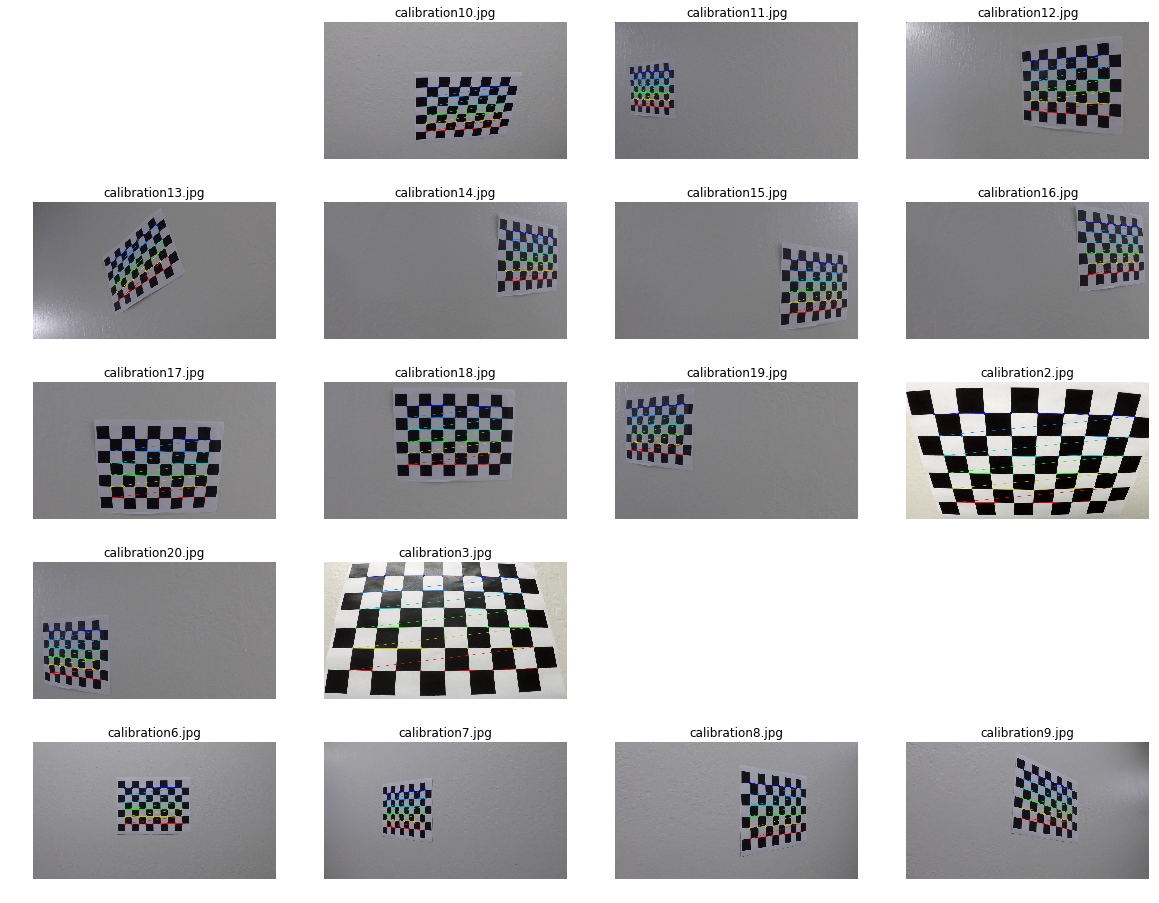

In [2]:
# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,9,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2) #x, y coordinates

fig = plt.figure(figsize=(20,16))
for i, fname in enumerate(images):
    img = mpimg.imread(fname)
    
    #Convert images to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    #Find the chessborad corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    
    #If Corners are found, add object points, image points
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        
        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        plt.subplot(5,4,i+1)
        plt.axis('off')
        plt.title(fname.split('\\')[-1])
        plt.imshow(img)


fig.savefig('output_images/chessboard.png')     

### Undistortion and visualzation

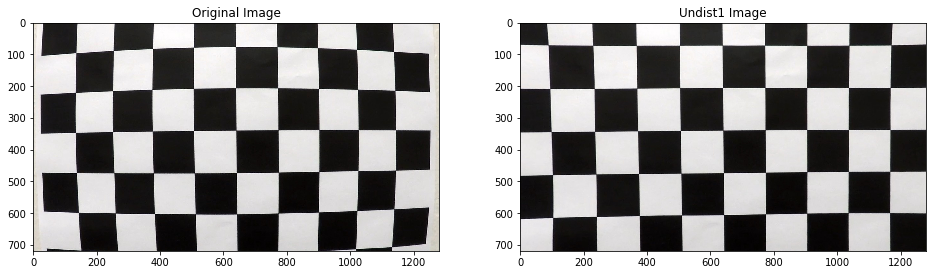

In [3]:
def undistort(img, objpoints=objpoints, imgpoints=imgpoints):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[0:2], None, None)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    
    return dst

def img_visual(imgname, img1, img2, gray='N'):
    #img = mpimg.imread(imgname)
    #dst = undistort(img, objp, imgp)
    plt.figure(figsize=(16,6))
    plt.subplot(1,2,1)
    plt.title('Original Image')
    plt.imshow(img1)
    plt.subplot(1,2,2)
    plt.title(imgname + ' Image')
    if gray == 'N':
        plt.imshow(img2)
    else:
        plt.imshow(img2, cmap='gray')
    plt.savefig('output_images/' + imgname)
    

img = mpimg.imread('camera_cal/calibration1.jpg')
undist = undistort(img)
img_visual('Undist1', img, undist)

## Pipeline (Singal image)

### Undistortion

Visualize Image before and after undistortion:
(720, 1280, 3)


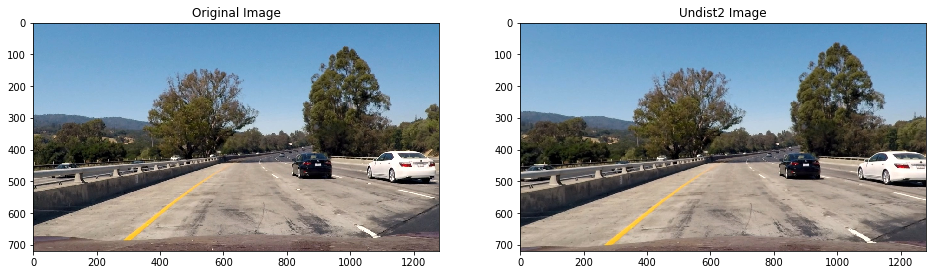

In [4]:
#img = mpimg.imread('test_images/straight_lines1.jpg')
img = mpimg.imread('test_images/test1.jpg')
undist = undistort(img)
print('Visualize Image before and after undistortion:')
print(img.shape)
img_visual('Undist2', img, undist)

### Perspective Transform

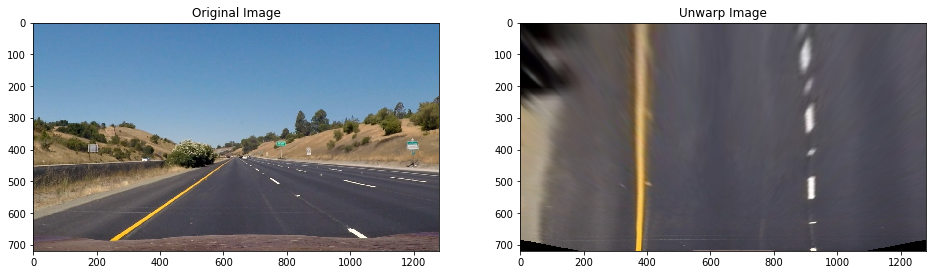

In [5]:
def unwarp(img):
    h,w = img.shape[:2]
    offset = 300
    
    src = np.float32([(0.46*w,0.62*h), (0.54*w, 0.62*h), (0.88*w, 0.95*h), (0.12*w, 0.95*h)])
    #src = np.float32([(538,490), (752, 490), (1060,680), (250, 680)])
    dst = np.float32([(offset, 0), (w-offset, 0), (w-offset, h), (offset, h)])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    warped = cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_LINEAR)
    
    return warped, M, Minv


img = mpimg.imread('test_images/straight_lines1.jpg')
undist = undistort(img)
img_visual('Unwarp', img, unwarp(undist)[0])

### Helper Functions

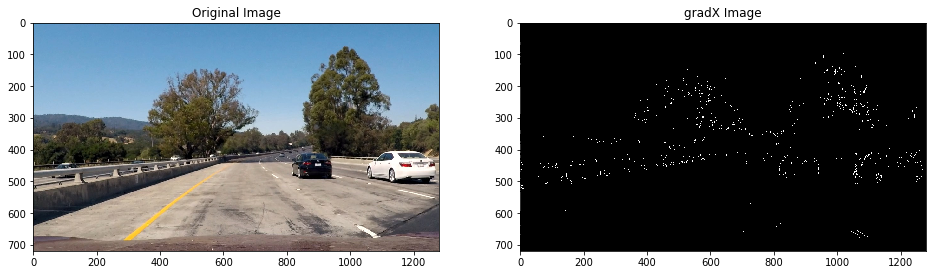

In [6]:
## Gradient Threshold, X and Y
def abs_sobel_threshold(img, orient='x', thresh=(0,255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
   
    output = np.zeros_like(scaled_sobel)
    output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    return output

img = mpimg.imread('test_images/test1.jpg')
grad_binary = abs_sobel_threshold(img, orient='x', thresh=(60,100))
img_visual('gradX', img, grad_binary, gray='Y')

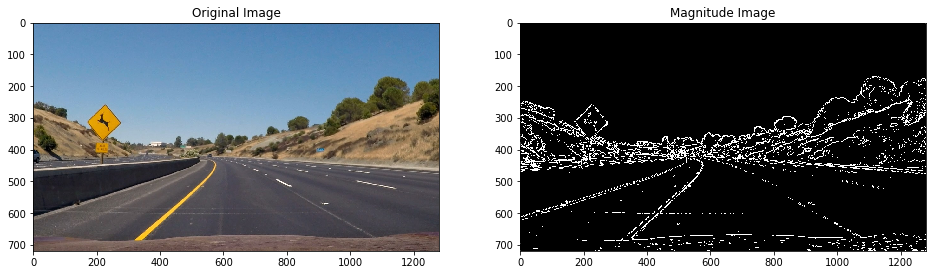

In [7]:
## Magnitude Threshold -- not used 
def mag_threshold(img, sobel_kernel=3, mag_thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
   
    output = np.zeros_like(gradmag)
    output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    return output

img = mpimg.imread('test_images/test2.jpg')
mag_binary = mag_threshold(img, sobel_kernel=3, mag_thresh=(30, 100))
img_visual('Magnitude', img, mag_binary, gray='Y')

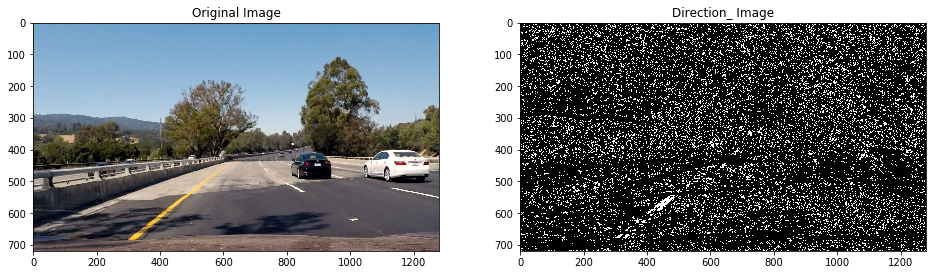

In [8]:
## Direction Threshold - not used
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    output =  np.zeros_like(absgraddir)
    output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    return output

img = mpimg.imread('test_images/test4.jpg')
dir_binary = dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.0))
img_visual('Direction_', img, dir_binary, gray='Y')

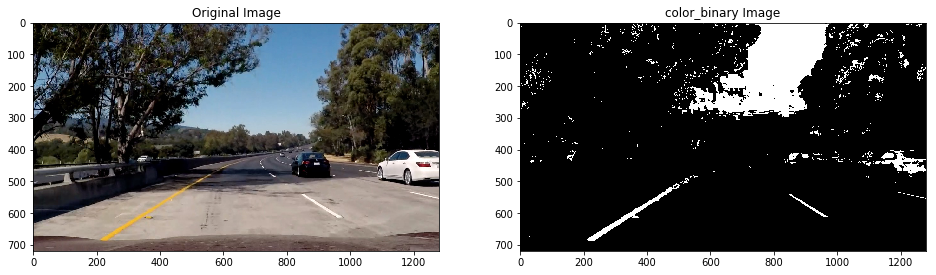

In [9]:
## Color threshold, S channel from HLS for Yellow lane, V channel from hsv for White lane
def color_threshold(img, sthresh=(0,255), vthresh=(0,255)):
    #binary threshold from hls s channel
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= sthresh[0]) & (s_channel <= sthresh[1])] = 1
    
    #binary threshold from hsv v channel
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    v_channel = hsv[:,:,2]
    v_binary = np.zeros_like(s_channel)
    v_binary[(v_channel >= vthresh[0]) & (v_channel <= vthresh[1])] = 1
    
    output = np.zeros_like(s_channel)
    output[(s_binary == 1) & (v_binary == 1)] = 1 
    
    return output

img = mpimg.imread('test_images/test5.jpg')
color_binary = color_threshold(img, sthresh=(100, 255), vthresh=(50, 255))
img_visual('color_binary', img, color_binary, gray='Y')

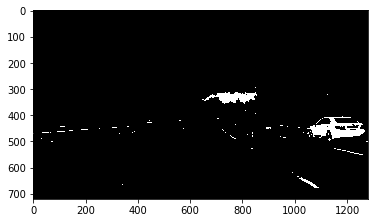

In [10]:
## White color mask to get a improved white line
def select_white(image): 
    # white color mask
    lower = np.uint8([190, 190, 190])
    upper = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(image, lower, upper)

    return white_mask

img = mpimg.imread('test_images/test1.jpg')
mask = select_white(img)
plt.imshow(mask, cmap='gray')

#mask

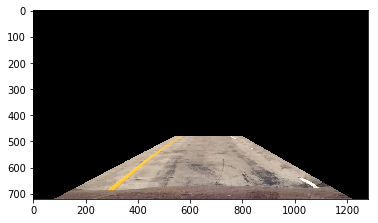

In [11]:
## Region of interest, not used in project Pipeline, could be used for chanllege video
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
      
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

img = mpimg.imread('test_images/test1.jpg')
vertices = np.array([[(80,720),(1220,720),(800,480),(540,480)]], np.int32)
masked_image = region_of_interest(img, vertices)
plt.imshow(masked_image, cmap ='gray')


### Get Binary image for Lane lines

In [12]:
# Finalize binary image with white mask, gradinet XY and color channel S and V
def binary(img):
    #plt.imshow(img)
    # White Mask
    mask = select_white(img)
    # Gradient X and Y
    gradX = abs_sobel_threshold(img, orient='x', thresh=(50,100))
    gradY = abs_sobel_threshold(img, orient='y', thresh=(25,100))
    # Color with HLS S channel and HSV V Channel
    color_binary = color_threshold(img, sthresh=(100, 255), vthresh=(50, 255))
    
    # Binary Image from above
    binary = np.zeros_like(img[:,:,0])
    binary[((gradX == 1) & (gradY == 1) | (color_binary == 1)|(mask != 0))] = 1
    
    # Region of Interest
    #vertices = np.array([[(80,720),(1220,720),(800,480),(540,480)]], np.int32)
    #masked_binary = region_of_interest(binary, vertices)
    
    return binary

### Find Lane Line 

In [13]:
## Define method to fit polynomial to binary image with lines extracted
## using sliding window on the first image, fast method afterwards
def polyfit(img, first_image = True, left_fit = None, right_fit = None):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((img, img, img))*255
    # Rectangle data for visualization
    rectangle_data = []
    
    if first_image:
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = np.int(img.shape[0]/nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = img.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 50
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []
        # Rectangle data for visualization
        rectangle_data = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = img.shape[0] - (window+1)*window_height
            win_y_high = img.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            rectangle_data.append((win_y_low, win_y_high, win_xleft_low, win_xleft_high,\
                                   win_xright_low, win_xright_high))
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &\
                              (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &\
                               (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 

        #left_fit, right_fit = (None, None)
        # Fit a second order polynomial to each
        #if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
        #if len(rightx) != 0:
        right_fit  = np.polyfit(righty, rightx, 2)

    
    # After first(single) image is processed, find the line based on previous result
    else:
        nonzero = img.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = 100
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin))\
                          & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin))\
                           & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        # Fit a second order polynomial to each
        #if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
        #if len(rightx) != 0:
        right_fit  = np.polyfit(righty, rightx, 2)
        
    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radius of curvature
    left_curverad =  ((1 + (2*left_fit_cr[0] *y_eval*ym_per_pix + left_fit_cr[1])**2) **1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Compute car position
    img_center = img.shape[1] / 2
    lane_center = (left_fitx[-1] + right_fitx[-1]) / 2
    offset_right_from_center_m = (lane_center-img_center)*xm_per_pix
    
    # Now our radius of curvature is in meters
    avg_radius_meters = np.mean([left_curverad, right_curverad])
    
    return out_img, avg_radius_meters, offset_right_from_center_m, left_fitx, right_fitx, ploty, left_fit, right_fit, histogram, rectangle_data
        


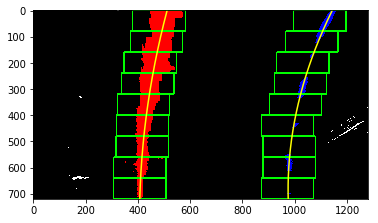

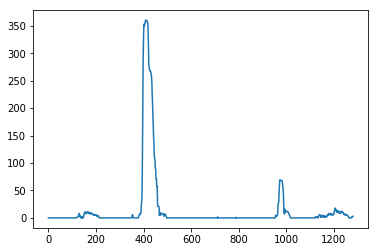

In [15]:
## First Frame Example - visualize sliding door and histogram
img = mpimg.imread('test_images/test4.jpg')
undist = undistort(img)
bi_img = binary(undist)
binary_warped = unwarp(bi_img)[0]
#plt.imshow(binary_warped)
img_lines, r_meters, right_from_center_m, left_fitx, right_fitx, ploty, left_fit, right_fit, histogram, rectangles\
= polyfit(binary_warped, first_image=True)

# Draw the rectangles windows on the visualization
for rect in rectangles:
    cv2.rectangle(img_lines,(rect[2],rect[0]),(rect[3],rect[1]),(0,255,0), 4) 
    cv2.rectangle(img_lines,(rect[4],rect[0]),(rect[5],rect[1]),(0,255,0), 4)

plt.imshow(img_lines)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.savefig('output_images/sliding_windows.png')
plt.figure()
plt.plot(histogram)
plt.savefig('output_images/histogram.png')


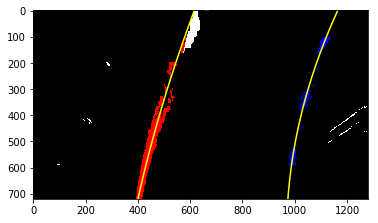

In [16]:
## Next Frame Example - visualize find line based on the previous fit
img = mpimg.imread('test_images/test6.jpg')
undist = undistort(img)
bi_img = binary(undist)
binary_warped = unwarp(bi_img)[0]
img_lines, r_meters, right_from_center_m, left_fitx, right_fitx, ploty, left_fit, right_fit, histogram, rectangles\
= polyfit(binary_warped, first_image=False, left_fit=left_fit, right_fit=right_fit)
plt.imshow(img_lines)
 
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')


### Draw the detected lane back to the Original Image

In [17]:
def draw_lines(img, binary_warped, Minv, left_fitx, right_fitx, ploty, radius, distance): 
    h,w = binary_warped.shape
    # new_img = np.copy(img)
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    warp = cv2.warpPerspective(color_warp, Minv, (w, h), flags=cv2.INTER_LINEAR) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, warp, 0.5, 0)
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result,'Curve Radius: %.1f m'%(radius),(50,50), font, 1,(255,255,100),2,cv2.LINE_AA)
    curve = 'left'
    if distance > 0:
        curve = 'right'
    distance = abs(distance)
    cv2.putText(result,'Vehicle is %.1fm '%(distance) + curve + ' from the Lane Center',(50,100), font, 1,(255,255,100),2,cv2.LINE_AA)

    
    return result


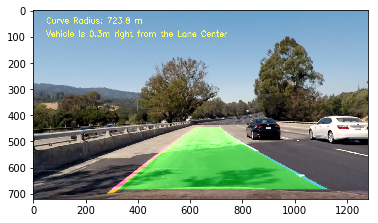

In [18]:
# Final output Example - with lane line and road parameters
img = mpimg.imread('test_images/test4.jpg')
undist = undistort(img)
bi_img = binary(undist)
binary_warped, Minv = unwarp(bi_img)[0], unwarp(bi_img)[2]
img_lines, r_meters, dist_from_center, left_fitx, right_fitx, ploty,\
left_fit, right_fit, histogram, rectangles = polyfit(binary_warped, first_image=True)
result = draw_lines(undist, binary_warped, Minv, left_fitx, right_fitx, ploty, r_meters, dist_from_center)

plt.imshow(result)

 ## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [19]:
images = glob.glob("test_images/[st]*.jpg")
images

['test_images\\straight_lines1.jpg',
 'test_images\\straight_lines2.jpg',
 'test_images\\test1.jpg',
 'test_images\\test2.jpg',
 'test_images\\test3.jpg',
 'test_images\\test4.jpg',
 'test_images\\test5.jpg',
 'test_images\\test6.jpg']

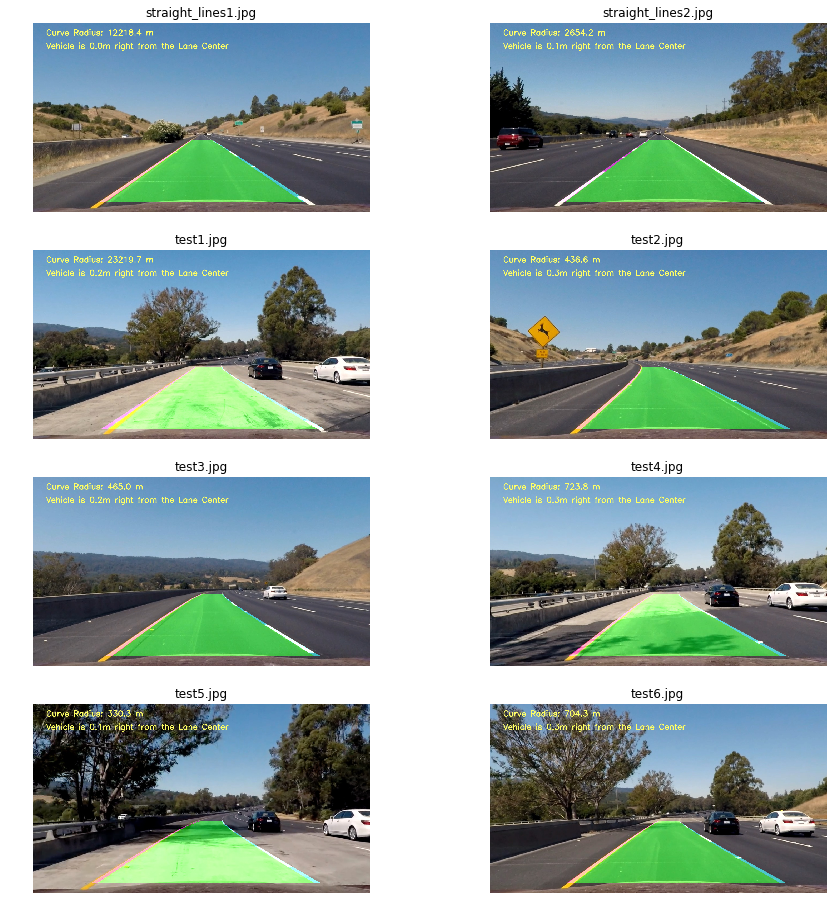

In [20]:
fig = plt.figure(figsize=(15,16))
for i, fname in enumerate(images):
    img = mpimg.imread(fname)
    undist = undistort(img)
    bi_img = binary(undist)
    binary_warped, Minv = unwarp(bi_img)[0], unwarp(bi_img)[2]
    img_lines, r_meters, dist_from_center, left_fitx, right_fitx, ploty,\
    left_fit, right_fit, histogram, rectangles = polyfit(binary_warped, first_image=True)
    
    result = draw_lines(undist, binary_warped, Minv, left_fitx, right_fitx, ploty, r_meters, dist_from_center)

    plt.subplot(4,2,i+1)
    plt.axis('off')
    plt.title(fname.split('\\')[-1])
    plt.imshow(result)


fig.savefig('output_images/final_output.png') 

left_fit, right_fit = (None, None)

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [25]:
# TODO: Build your pipeline that will draw lane lines on the input images
# then return the output with Laneline Curve radius and Vehicle position.

def image_pipeline(image):
    global left_fit, right_fit
    undist = undistort(image)
    binary_img = binary(undist)
    b_w, Minv = unwarp(binary_img)[0], unwarp(binary_img)[2]
    
    if (left_fit == None) or (right_fit == None) :
        #print('2', left_fit)
        img_lines, r_meters, dist_from_center, left_fitx, right_fitx, ploty, left_fit,\
        right_fit, histogram, rectangles = polyfit(b_w, first_image=True)
        #print('3',left_fit)
        output = draw_lines(undist, b_w, Minv, left_fitx, right_fitx, ploty, r_meters,\
                            dist_from_center)
  
        
    
    else:
        img_lines, r_meters, dist_from_center, left_fitx, right_fitx, ploty, left_fit,\
        right_fit, histogram, rectangles = polyfit(b_w, first_image=False, left_fit=left_fit, right_fit=right_fit)
        
        output = draw_lines(undist, b_w, Minv, left_fitx, right_fitx, ploty, r_meters,\
                            dist_from_center)
            
    return output
        


## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`project_video.mp4`

`challenge_video.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [22]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [23]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    global left_fit, right_fit
    #print ('1', left_fit)
    left_fit, right_fit = (None, None)
    result = image_pipeline(image)

    return result

Let's try the one with the project video first ...

In [24]:
project_output = 'project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("project_video.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
project_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time project_clip.write_videofile(project_output, audio=False)


[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████████████████████████████████▉| 1260/1261 [24:55<00:01,  1.19s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 24min 57s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [30]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))

Now for the one with the challenge video. This one's more tricky!

In [26]:
challenge_output = 'challenge_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip2 = VideoFileClip('challenge_video.mp4').subclip(0,4)
clip2 = VideoFileClip('challenge_video.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)


[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4


100%|████████████████████████████████████████████████████████████████████| 485/485 [09:31<00:00,  1.17s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output.mp4 

Wall time: 9min 32s


In [27]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


#### Test works on Chanllenge videos - need further imporvement

In [ ]:
# Get some test image from challenge video
vidcap = cv2.VideoCapture('challenge_video.mp4')
vidcap.set(cv2.CAP_PROP_POS_MSEC,0000)      # just cue to 20 sec. position
success,image = vidcap.read()
if success:
    cv2.imwrite("frame0sec.jpg", image)     # save frame as JPEG file
    #cv2.imshow("20sec",image)
    cv2.waitKey

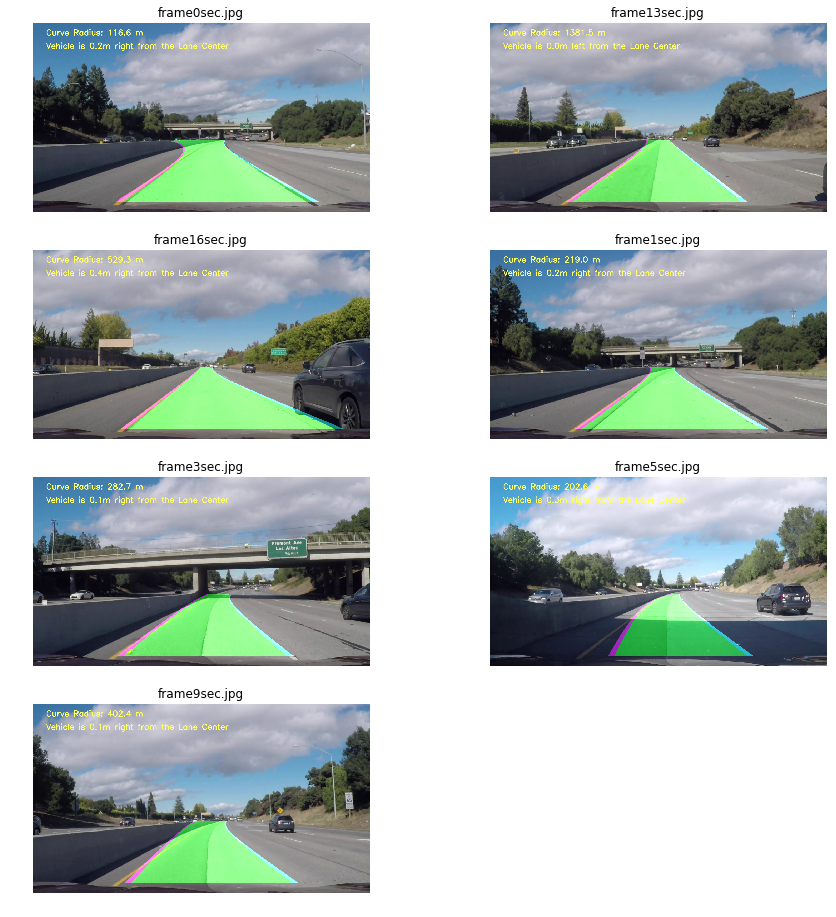

In [34]:
# Test pipeline with single image from challenge video
images = glob.glob("test_images/frame*.jpg")
fig = plt.figure(figsize=(15,16))
for i, fname in enumerate(images):
    img = mpimg.imread(fname)
    binary_warped, Minv = unwarp(binary(img))[0], unwarp(binary(img))[2]
    img_lines, r_meters, dist_from_center, left_fitx, right_fitx, ploty,\
    left_fit, right_fit, histogram, rectangles = polyfit(binary_warped, first_image=True)
    result = draw_lines(img, binary_warped, Minv, left_fitx, right_fitx, ploty, r_meters, dist_from_center)

    plt.subplot(4,2,i+1)
    plt.axis('off')
    plt.title(fname.split('\\')[-1])
    plt.imshow(result)


fig.savefig('output_images/challenge_output.png') 


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [28]:
harder_output = 'harder_challenge_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip3 = VideoFileClip('harder_challenge_video.mp4').subclip(0,36)
## clip3 = VideoFileClip('harder_challenge_video.mp4')
harder_clip = clip3.fl_image(process_image)
%time harder_clip.write_videofile(harder_output, audio=False)


[MoviePy] >>>> Building video harder_challenge_video_output.mp4
[MoviePy] Writing video harder_challenge_video_output.mp4


100%|███████████████████████████████████████████████████████████████████▉| 900/901 [18:05<00:01,  1.20s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_video_output.mp4 

Wall time: 18min 8s


In [29]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(harder_output))